# Butterfly Factorization

Following the paper "[An algorithm for the rapid evaluation 
of special function transforms](https://doi.org/10.1016/j.acha.2009.08.005)", by Michael O’Neil, Franco Woolfe, Vladimir Rokhlin.

In [1]:
import numpy as np
import numpy.linalg as la
import scipy.linalg.interpolative as sli
import matplotlib.pyplot as plt

## A Matrix for the Discrete Fourier Transform

In [2]:
nlevels = 6
n = 2**(nlevels + 2)

omega = np.exp(2*np.pi*1j/n)

ns = np.arange(n)
exponents = ns.reshape(-1, 1) * ns

dft = 1/np.sqrt(n)*omega**exponents
idft = 1/np.sqrt(n)*omega**-exponents

In [3]:
la.norm(np.abs(idft @ dft) - np.eye(n))

1.1675534858569826e-12

## A Matrix Slicing Helper

In [4]:
class Level:
    def __init__(self, level, nlevels, n=None):
        self.level = level
        self.nlevels = nlevels
        
        if level > nlevels:
            raise ValueError("level too large")
            
        if n is None:
            n = 2**nlevels
        self.n = n
        
    @property
    def nblock_rows(self):
        return 2**self.level
        
    @property
    def block_nrows(self):
        return self.n//self.nblock_rows

    @property
    def nblock_cols(self):
        return 2**(self.nlevels-self.level)
        
    @property
    def block_ncols(self):
        return self.n//self.nblock_cols
    
    def matview(self, bi, bj, mat):
        br = self.block_nrows
        bc = self.block_ncols
        return mat[br*bi:br*(bi+1), bc*bj:bc*(bj+1)]
    
    def rowview(self, bi, vec):
        br = self.block_nrows
        return vec[br*bi:br*(bi+1)]
    
    def colview(self, bj, vec):
        bc = self.block_ncols
        return vec[bc*bj:bc*(bj+1)]

In [5]:
Level(0, nlevels, 256).matview(0, 0, dft).shape

(256, 4)

## A Helper for the ID

In [6]:
epsilon = 1e-10

def intp_decomp(A):
    k, idx, proj = sli.interp_decomp(A, epsilon)
    sort_idx = np.argsort(idx)
    B = A[:,idx[:k]]
    P = np.hstack([np.eye(k), proj])[:,np.argsort(idx)]
    return B, P

In [7]:
def make_low_rank_matrix(n):
    A0 = np.random.randn(n, n)
    U0, sigma0, VT0 = la.svd(A0)
    sigma = np.exp(-np.arange(n))
    return (U0 * sigma).dot(VT0)

Atest = make_low_rank_matrix(100)
Btest, Ptest = intp_decomp(Atest)

la.norm(Atest - Btest@Ptest)/la.norm(Atest)

1.5592788371504185e-10

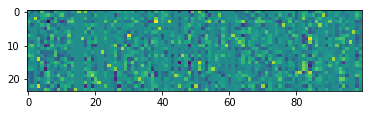

In [8]:
plt.imshow(Ptest)

## Precomputation

In [9]:
A = dft

# keys: [level][i, j]
Ps = [{} for i in range(nlevels+1)]
Bs = [{} for i in range(nlevels+1)] 

### Level 0

In [10]:
lev = Level(0, nlevels, n)

assert lev.nblock_rows == 1
for i in range(lev.nblock_rows):
    for j in range(lev.nblock_cols):
        Bs[0][i, j], Ps[0][i, j] = intp_decomp(lev.matview(i, j, A))

### Levels 1, ..., L

In [11]:
for ilev in range(1, nlevels + 1):
    lev = Level(ilev, nlevels, n)

    for j in range(lev.nblock_rows):
        for k in range(lev.nblock_cols):
            # only process even j
            if j % 2 != 0:
                continue
                
            bblock = np.hstack((
                Bs[ilev-1][j//2, 2*k],
                Bs[ilev-1][j//2, 2*k+1],
                ))
            bblock_top = bblock[:lev.block_nrows]
            bblock_bottom = bblock[lev.block_nrows:]
            assert len(bblock_top)*2 == len(bblock)
            
            Bs[ilev][j, k], Ps[ilev][j, k] = intp_decomp(bblock_top)
            Bs[ilev][j+1, k], Ps[ilev][j+1, k] = intp_decomp(bblock_bottom)

Only the last-level $B$ actually needs to be retained:

In [12]:
LLB = Bs[-1]
del Bs

## Matvec

First, generate a random input:

In [13]:
x = np.random.randn(n)

### Setup

In [14]:
# keys: [ilevel][i, j]
betas = [{} for i in range(nlevels+1)]

### Level 0

In [15]:
lev = Level(0, nlevels, n)

assert lev.nblock_rows == 1
for i in range(lev.nblock_rows):
    for j in range(lev.nblock_cols):
        betas[0][i, j] = Ps[0][i, j] @ lev.colview(j, x)

### Level 1, ..., L

In [16]:
for ilev in range(1, nlevels + 1):
    lev = Level(ilev, nlevels, n)

    for j in range(lev.nblock_rows):
        for k in range(lev.nblock_cols):
            beta_glued = np.hstack((
                betas[ilev-1][j//2, 2*k],
                betas[ilev-1][j//2, 2*k+1]
                ))
            
            betas[ilev][j, k] = Ps[ilev][j, k] @ beta_glued

### Postprocess

In [17]:
Ax = np.zeros(n, dtype=np.complex128)

lev = Level(nlevels, nlevels, n)

assert lev.nblock_cols == 1
for j in range(lev.nblock_rows):
    for k in range(lev.nblock_cols):
        lev.rowview(j, Ax)[:] = LLB[j, k] @ betas[nlevels][j, k]

In [18]:
la.norm(Ax - A@x)/la.norm(A@x)

3.684139472991048e-11